# Курс "Методы Оптимизаций"
# 3 курс ФПМИ МФТИ, осень 2022
##  Multi-armed bandit сравнение реализации
### Захаров Георгий, Б05-024

Постановка задачи: Пусть к нам пришло несколько экспертов в некоторой области. Каждый из них выдал ответ на какой-то заранее поставленный вопрос. Наша задача - найти верный ответ на вопрос, но так как сами мы в нем не разбираемся, то нам нужно выбрать эксперта, чей ответ верен и довериться ему в этом вопросе. При этом мы хотим, чтобы вероятность ошибки была минимальной. Проще говоря мы хотим сойтись к оптимальному решению как можно быстрее.
Эта задача относится к классу задач о взвешенном голосовании (также известном как $multi-armed$ $bandit$ $problem$). Для ее решения мы реализуем несколько разных алгоритмов и сравним их успех.

Начнем с общей структуры. Класс $Expert$ будет имитировать экспертов: у каждого будет его точность в предположениях. Для простоты, будем считать, что у нас всего два варианта ответа, и каждый эксперт выбирает либо верный $1$, либо неверный $0$.

In [1]:
import numpy as np
from scipy import stats as sps
from matplotlib import pyplot as plt
import seaborn as sns

class Expert:
    def __init__(self, accuracy):
        self.accuracy = accuracy

    def make_prediction(self):
        return sps.bernoulli(self.accuracy).rvs()

In [14]:
expert_number = 16
max_iters = 256
accuracies = np.random.uniform(0, 1, expert_number)
experts = [Expert(accuracy) for accuracy in accuracies]
print(max(accuracies))

0.9798072738614575


Первая реализация будет выбирать вариант за который проголосовала хотя бы половина экспертов. Если предсказание окажется неверным, то всех кого мы послушали $-$ выгоняем. Повторяем процесс пока у нас не останется только один эксперт. Тогда уже делать нечего $-$ слушаем только его.
Проще говоря мы выбираем голос большинства с весами, но веса у нас бинарные: либо 1, либо 0.

In [3]:
def binary_weights_majority_vote(experts, max_iters):
    weights = np.ones(len(experts))
    our_answer = np.zeros(max_iters)

    for i in range(max_iters):
        predictions = np.array([expert.make_prediction() for expert in experts])
        weighted_predictions = predictions * weights
        is_incorrect_answer = (np.sum(weighted_predictions) < np.sum(weights) / 2 or
                              (np.sum(weighted_predictions) == np.sum(weights) / 2 and
                                  sps.bernoulli(0.5).rvs()))
        if not is_incorrect_answer:
            our_answer[i] = 1
        if (is_incorrect_answer and not
                np.sum(weighted_predictions) == 0 and not
                np.sum(weights) == 1):
            weights = np.where(predictions == 0, 0, weights)
    return np.cumsum(our_answer) / np.arange(1, max_iters + 1)

Вторая реализация тоже будет выбирать вариант за который проголосовала большинство экспертов, только в этот раз мы будем поддерживать ненулевые веса у всех экспертов. А именно мы будем уменьшать вес тех, кто ответил неверно после каждой итерации, так как мы хотим реже слушать тех, кто чаще ошибается. Веса будут обновляться по формуле:
$$
w_{i+1} = w_i(1 - I_{[p_i = 0]}\epsilon)
$$
где $p_{i}$ $-$ ответ $i-$го эксперта, а $\epsilon$ $-$ гиперпараметр.
Стандартный параметр = 0.1, а оптимальный $= min(\sqrt{\frac{experts \cdot ln(experts)}{iters}}, 0.5)$ (доказательство прилагается в отчете).


In [4]:
def decreasing_weights_majority_vote(experts, max_iters, epsilon=0.1):
    weights = np.ones(len(experts))
    our_answer = np.zeros(max_iters)

    for i in range(max_iters):
        predictions = np.array([expert.make_prediction() for expert in experts])
        weighted_predictions = predictions * weights
        is_incorrect_answer = (np.sum(weighted_predictions) < np.sum(weights) / 2 or
                              (np.sum(weighted_predictions) == np.sum(weights) / 2 and
                                  sps.bernoulli(0.5).rvs()))
        weights = np.where(predictions == 0, weights * (1 - epsilon), weights)
        if not is_incorrect_answer:
            our_answer[i] = 1
    return np.cumsum(our_answer) / np.arange(1, max_iters + 1)

Третья реализация также требует пересчет весов, только при ошибке мы будем уменьшать вес, а при успехе наоборот $-$ увеличивать. Веса будут обновляться по формуле:
$$w_{i+1} = \begin{cases} w_i(1 - \epsilon) & \mbox{, если эксперт ошибся} \\
w_i(1 + \epsilon) & \mbox{, если эксперт оказался прав}
\end{cases}$$
Теперь вместо того чтобы брать сумму взвешенных весов, попробуем выбирать эксперта случайно основываясь на его весе, то есть теперь алгоритм будет рандомизированный.

In [5]:
import random

def randomized_weights_majority_vote(experts, max_iters, epsilon=0.1):
    weights = np.ones(len(experts))
    our_answer = np.zeros(max_iters)

    for i in range(max_iters):
        predictions = np.array([expert.make_prediction() for expert in experts])
        predict = random.choices(predictions, weights=weights)[0]
        weights = np.where(predictions == 0, weights * (1 - epsilon), weights * (1 + epsilon))
        if predict == 1:
            our_answer[i] = 1
    return np.cumsum(our_answer) / np.arange(1, max_iters + 1)

Последний алгоритм будет делать предположения основываясь на апостериорном для каждого эксперта распределении Бернулли. Мы будем пытаться предугадать распределение каждого отдельного эксперта. При этом параметры $Beta-$распределения обновляются так: если эксперт ошибся, то $\alpha \rightarrow \alpha + 1$, а $\beta \rightarrow \beta$, а если эксперт оказался прав, то $\alpha \rightarrow \alpha$, а $\beta \rightarrow \beta + 1$. Теперь, чтобы сделать предсказание, мы будем брать среднее арифметическое от апостериорных распределений каждого эксперта. Если среднее арифметическое больше 0.5, то мы будем предсказывать 1, иначе 0.

In [6]:
def beta_weights_majority_vote(experts, max_iters):
    correct_answers = np.ones(len(experts))
    incorrect_answers = np.ones(len(experts))
    our_answer = np.zeros(max_iters)

    for i in range(max_iters):
        predictions = np.array([expert.make_prediction() for expert in experts])
        index = np.argmax(sps.beta.rvs(correct_answers, incorrect_answers))
        predict = predictions[index]
        correct_answers += predictions
        incorrect_answers += 1 - predictions
        if predict == 1:
            our_answer[i] = 1
    return np.cumsum(our_answer) / np.arange(1, max_iters + 1)

А теперь нарисуем графики для всех наших решений и усредним значения, чтоб график был более точным.


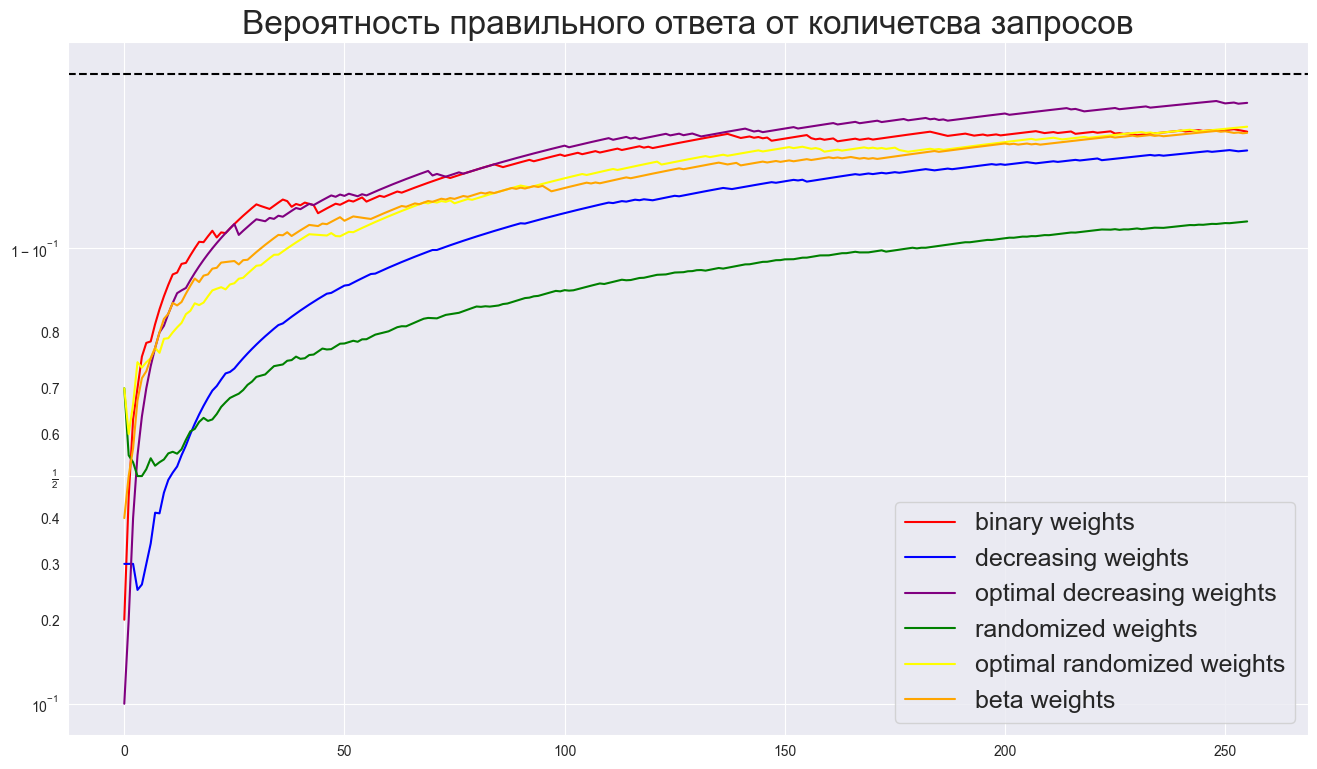

In [17]:
plt.figure(figsize=(16, 9))

plt.plot(np.array([binary_weights_majority_vote(experts, max_iters) for i in range(10)]).mean(axis=0), label='binary weights', color='red')

plt.plot(np.array([decreasing_weights_majority_vote(experts, max_iters) for i in range(10)]).mean(axis=0), label='decreasing weights', color='blue')

plt.plot(np.array([decreasing_weights_majority_vote(experts, max_iters, epsilon=np.sqrt(expert_number * np.log(expert_number) / max_iters)) for i in range(10)]).mean(axis=0), label='optimal decreasing weights', color='purple')

plt.plot(np.array([randomized_weights_majority_vote(experts, max_iters) for i in range(10)]).mean(axis=0), label='randomized weights', color='green')

plt.plot(np.array([randomized_weights_majority_vote(experts, max_iters, epsilon=np.sqrt(expert_number * np.log(expert_number) / max_iters)) for i in range(10)]).mean(axis=0), label='optimal randomized weights', color='yellow')

plt.plot(np.array([beta_weights_majority_vote(experts, max_iters) for i in range(10)]).mean(axis=0), label='beta weights', color='orange')

plt.axline((0, max(accuracies)), (max_iters, max(accuracies)), color='black', linestyle='--')
plt.title("Вероятность правильного ответа от количетсва запросов", fontsize=24)
plt.yscale('logit')
plt.legend(fontsize=18)
plt.show()